In [24]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [25]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [26]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [27]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-04-16 02:41:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.20.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-04-16 02:41:39 (83.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



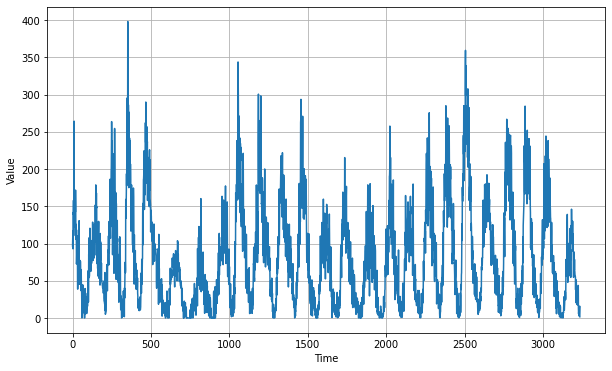

In [28]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [30]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [32]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [67]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 26ms/step - loss: 75.2146 - mae: 75.7104
Epoch 2/100
12/12 [==============================] - 0s 30ms/step - loss: 74.4120 - mae: 74.9082
Epoch 3/100
12/12 [==============================] - 0s 31ms/step - loss: 73.0553 - mae: 73.5514
Epoch 4/100
12/12 [==============================] - 1s 32ms/step - loss: 69.8781 - mae: 70.3746
Epoch 5/100
12/12 [==============================] - 0s 30ms/step - loss: 67.6174 - mae: 68.1144
Epoch 6/100
12/12 [==============================] - 0s 30ms/step - loss: 65.6892 - mae: 66.1860
Epoch 7/100
12/12 [==============================] - 1s 31ms/step - loss: 63.8930 - mae: 64.3902
Epoch 8/100
12/12 [==============================] - 1s 32ms/step - loss: 61.7642 - mae: 62.2615
Epoch 9/100
12/12 [==============================] - 1s 32ms/step - loss: 59.7701 - mae: 60.2672
Epoch 10/100
12/12 [=====

(1e-08, 0.1, 0.0, 60.0)

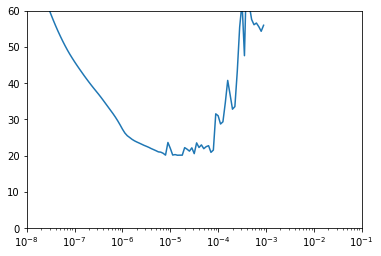

In [68]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 60])

In [69]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=256, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
12/12 [==============================] - 3s 25ms/step - loss: 58.1305 - mae: 58.6275
Epoch 2/500
12/12 [==============================] - 0s 30ms/step - loss: 37.4677 - mae: 37.9641
Epoch 3/500
12/12 [==============================] - 0s 29ms/step - loss: 31.6462 - mae: 32.1418
Epoch 4/500
12/12 [==============================] - 0s 31ms/step - loss: 28.0596 - mae: 28.5544
Epoch 5/500
12/12 [==============================] - 0s 28ms/step - loss: 25.5143 - mae: 26.0089
Epoch 6/500
12/12 [==============================] - 0s 30ms/step - loss: 23.9827 - mae: 24.4769
Epoch 7/500
12/12 [==============================] - 0s 31ms/step - loss: 22.8376 - mae: 23.3311
Epoch 8/500
12/12 [==============================] - 1s 31ms/step - loss: 22.1790 - mae: 22.6722
Epoch 9/500
12/12 [==============================] - 0s 31ms/step - loss: 21.6081 - mae: 22.1007
Epoch 10/500
12/12 [==============================] - 0s 30ms/step - loss: 21.4412 - mae: 21.9342
Epoch 11/500
12/12 [=========

In [62]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

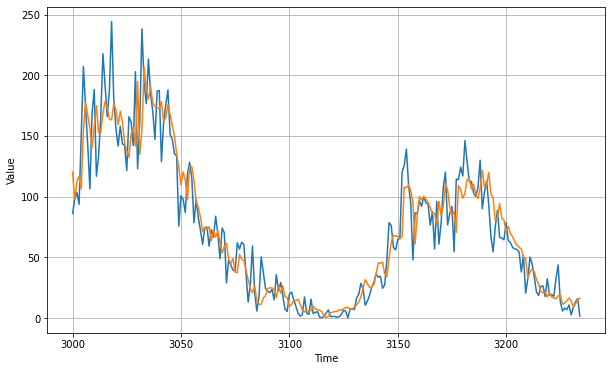

In [63]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [64]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

13.906202

<Figure size 432x288 with 0 Axes>

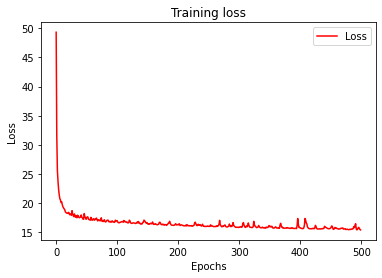

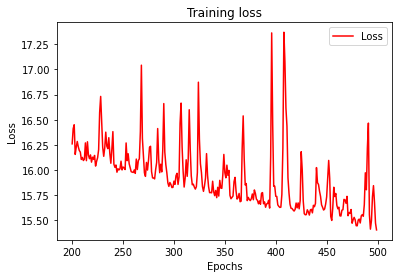

<Figure size 432x288 with 0 Axes>

In [65]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [66]:
print(rnn_forecast)

[1.20202950e+02 9.75314178e+01 1.12166939e+02 1.16937485e+02
 1.06132675e+02 1.54529266e+02 1.77649857e+02 1.66618988e+02
 1.56130508e+02 1.40512436e+02 1.57308640e+02 1.74982269e+02
 1.52806992e+02 1.52438934e+02 1.68652405e+02 1.78260239e+02
 1.73369186e+02 1.63921722e+02 1.63145126e+02 1.76313797e+02
 1.71506195e+02 1.59304459e+02 1.70418091e+02 1.61539474e+02
 1.44286026e+02 1.37712311e+02 1.32296860e+02 1.51461929e+02
 1.56729004e+02 1.41582794e+02 1.94889053e+02 1.34882111e+02
 1.54735703e+02 2.06534027e+02 1.87595337e+02 1.80388931e+02
 1.90675919e+02 1.77221710e+02 1.74277023e+02 1.73295929e+02
 1.72402557e+02 1.78167694e+02 1.61525070e+02 1.65032928e+02
 1.75721802e+02 1.67220230e+02 1.58379105e+02 1.50033569e+02
 1.35256546e+02 1.24156151e+02 1.09649696e+02 1.20322990e+02
 1.13324570e+02 9.73971329e+01 1.24798813e+02 1.24901009e+02
 1.13259193e+02 9.59199905e+01 9.09806366e+01 8.31965561e+01
 7.14726410e+01 7.47831192e+01 7.27515259e+01 7.51613998e+01
 6.37439804e+01 7.174700